#### The following script reproduces the original model of grid cells proposed by:

Guanella, Alexis, Daniel Kiper, and Paul Verschure. "A model of grid cells based on a twisted torus topology." International journal of neural systems 17, no. 04 (2007): 231-240.

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage.filters as filt

Build a virtual spatial navigation trajectory

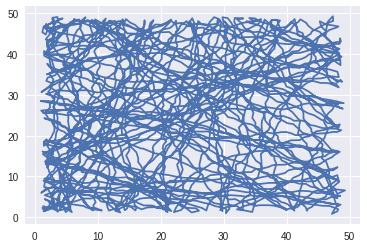

In [2]:
arena_size = 50

arenaX = [0,arena_size]
arenaY = [0,arena_size]

## Initial position
Txx = [arenaX[1]/2]
Tyy = [arenaY[1]/2]

def conv(ang):
    x = np.cos(np.radians(ang)) 
    y = np.sin(np.radians(ang)) 
    return x , y

def random_navigation(length):
    thetaList = []

    theta = 90
    counter = 0
    lenght_counter = 0
    for i in range(length):
        lenght_counter += 1

        prevTheta = np.copy(theta)

        if( Txx[-1]<2 ): theta = np.random.randint(-85,85)

        if( Txx[-1]>arena_size-2 ): theta = np.random.randint(95,260)

        if( Tyy[-1]<2 ): theta = np.random.randint(10,170)

        if( Tyy[-1]>arena_size-2 ): theta = np.random.randint(190,350)


        Txx.append( Txx[-1]+conv(theta)[0] + np.random.uniform(-0.5,0.5) )
        Tyy.append( Tyy[-1]+conv(theta)[1] + np.random.uniform(-0.5,0.5)  )

        cx = abs( Txx[-1] - Txx[-2]  )
        cy = abs( Tyy[-1] - Tyy[-2]  )
        h = np.sqrt( cx**2 + cy**2  )
        counter+=h

        if(theta != prevTheta or i == length-1):
            thetaList.append( [prevTheta, conv(prevTheta)[0], conv(prevTheta)[1], counter]  )
            counter = 0
    
    plt.plot(Txx,Tyy, '-')
    plt.show()


random_navigation(5000)

Txx = np.array(Txx)
Tyy = np.array(Tyy)



Grid class implementing the actual computational model of grid cells

In [0]:
class Grid():
    def __init__(self):
        
        self.mm = 20
        self.nn = 20
        self.TAO = 0.9
        self.II = 0.3
        self.SIGMA = 0.24
        self.SIGMA2 = self.SIGMA**2
        self.TT = 0.05
        self.grid_gain = [0.04,0.05,0.06,0.07,0.08]
        self.grid_layers = len(self.grid_gain)  
        self.grid_activity = np.random.uniform(0,1,(self.mm,self.nn,self.grid_layers))  
        self.distTri = self.buildTopology(self.mm,self.nn)


    def update(self, speedVector):

        self.speedVector = speedVector
        
        grid_ActTemp = []
        for jj in range(0,self.grid_layers):
            rrr = self.grid_gain[jj]*np.exp(1j*0)
            matWeights = self.updateWeight(self.distTri,rrr)
            activityVect = np.ravel(self.grid_activity[:,:,jj])
            activityVect = self.Bfunc(activityVect, matWeights)
            activityTemp = activityVect.reshape(self.mm,self.nn)
            activityTemp += self.TAO *( activityTemp/np.mean(activityTemp) - activityTemp)
            activityTemp[activityTemp<0] = 0

            self.grid_activity[:,:,jj] = (activityTemp-np.min(activityTemp))/(  np.max(activityTemp)-np.min(activityTemp)) * 30  ##Eq 2
                        

    def buildTopology(self,mm,nn):  # Build connectivity matrix     ### Eq 4
        mmm = (np.arange(mm)+(0.5/mm))/mm
        nnn = ((np.arange(nn)+(0.5/nn))/nn)*np.sqrt(3)/2
        xx,yy = np.meshgrid(mmm, nnn)
        posv = xx+1j * yy
        Sdist = [ 0+1j*0, -0.5+1j*np.sqrt(3)/2, -0.5+1j*(-np.sqrt(3)/2), 0.5+1j*np.sqrt(3)/2, 0.5+1j*(-np.sqrt(3)/2), -1+1j*0, 1+1j*0]      
        xx,yy = np.meshgrid( np.ravel(posv) , np.ravel(posv) )
        distmat = xx-yy
        for ii in range(len(Sdist)):
            aaa1 = abs(distmat)
            rrr = xx-yy + Sdist[ii]
            aaa2 = abs(rrr)
            iii = np.where(aaa2<aaa1)
            distmat[iii] = rrr[iii]
        return distmat.transpose()

    def updateWeight(self,topology,rrr): # Slight update on weights based on speed vector.
        matWeights = self.II * np.exp((-abs(topology-rrr*self.speedVector)**2)/self.SIGMA2) - self.TT   ## Eq 3
        return matWeights

    def Bfunc(self,activity, matWeights):  ## Eq 1
        activity += np.dot(activity,matWeights)
        return activity

# Simulation

In [0]:
grid = Grid()

log_grid_cells = []
for i in range(1,Txx.size):

    speedVector = (Txx[i]-Txx[i-1])+1j*(Tyy[i]-Tyy[i-1])

    grid.update(speedVector)
    log_grid_cells.append( grid.grid_activity.flatten()  )
    
log_grid_cells = np.array(log_grid_cells)

# Plot

In [0]:
xx = np.copy(Txx[1:])
yy = np.copy(Tyy[1:])
dv_levels = 5

### Spikes in arena

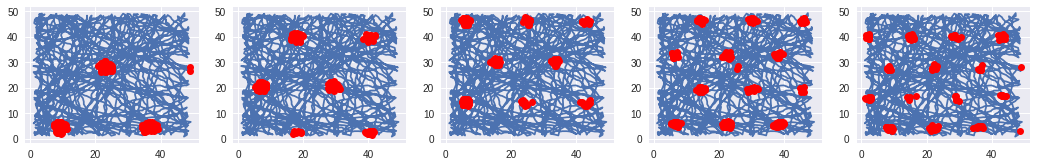

In [6]:
plt.figure(figsize=(18,2.5))


for cell_num in range(dv_levels):

    celula = log_grid_cells[:,cell_num]

    pos_spike_idx = np.where( celula > celula.max()*.9 )[0]

    
    plt.subplot(1,dv_levels,cell_num+1)
    plt.plot(xx,yy)
    plt.plot(   xx[pos_spike_idx] , yy[pos_spike_idx], 'or' )

# Ratemaps

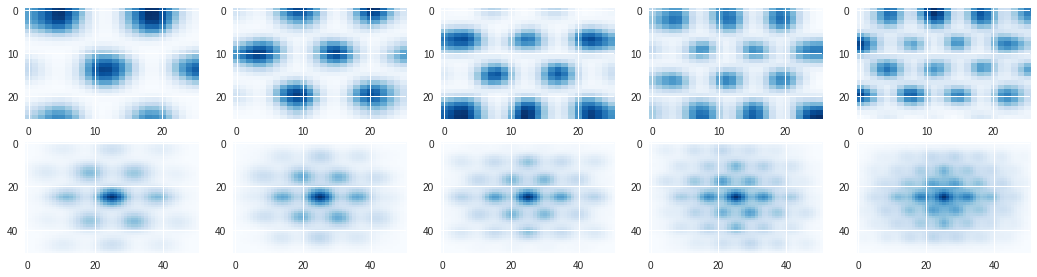

In [7]:


SIGMA2 = 15
maxxx = [ np.max(xx) , np.max(yy)  ]
arena_width = max(maxxx)+2
xxA,yyA = np.meshgrid(np.arange(0,arena_width,2),np.arange(0,arena_width,2))
xxA = np.ravel(xxA)
yyA = np.ravel(yyA)

plt.figure(figsize=(18,4.5))


for cell_num in range(dv_levels):

    ###### Bined arena
    celula = log_grid_cells[:,cell_num]

    arenaOpp = np.zeros(xxA.size)
    arena = np.zeros(xxA.size)
    for ii in range(len(xxA)):
        arenaOpp[ii] = np.sum(np.exp(-np.abs((xxA[ii]+1j*yyA[ii])-(xx+1j*yy))**2/SIGMA2))
        arena[ii] = np.sum(np.exp(-np.abs((xxA[ii]+1j*yyA[ii])-(xx+1j*yy))**2/SIGMA2)* celula )/arenaOpp[ii]
    arena = arena.reshape(len(np.arange(0,arena_width,2)),len(np.arange(0,arena_width,2)))

    autocorrel = signal.correlate2d(arena,arena)


    plt.subplot(2,dv_levels,cell_num+1)
    plt.imshow(  arena, aspect='auto', cmap='Blues' )

    plt.subplot(2,dv_levels,cell_num+1+dv_levels)
    plt.imshow(  autocorrel, aspect='auto', cmap='Blues' )


plt.show()